<a href="https://colab.research.google.com/github/vikpy/DLSem3/blob/master/Assignment_8_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download dataset of indian elephant, african elephant and tusker. Find which pretrained model get highest accuracy**

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import cv2
import PIL.Image
import urllib
import os
import pandas as pd


wnids = {
         
         'tusker' : 'n01871265',
         
         'indian_ele' : 'n02504013',

         'african_ele' : 'n02504458'

         }
image_net_path = 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid='
pages = {}
for wnid in wnids.keys():
  temp = requests.get(image_net_path + wnids[wnid])
  pages[wnid] = str(BeautifulSoup(temp.content, 'html.parser')).split('\r\n')

In [2]:

# Making directories for the train set 
!mkdir /content/train 
!mkdir /content/train/tusker 
!mkdir /content/train/indian_ele 
!mkdir /content/train/african_ele 

# making directories for the test set
!mkdir /content/validation 
!mkdir /content/validation/tusker 
!mkdir /content/validation/indian_ele 
!mkdir /content/validation/african_ele

# making directories for the test set 
!mkdir /content/test/ 
!mkdir /content/test/test

In [3]:
def url_to_image(url):
  import numpy as np
  import cv2
  import urllib
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
  return image

In [4]:
n_of_training_images=150#the number of training images to use

for class_ in pages:
  for progress in range(n_of_training_images):
      if(progress%20==0):
          print(progress)
      if not pages[class_][progress] == None:
        try:
          I = url_to_image(pages[class_][progress])
          if (len(I.shape)) == 3: #check if the image has width, length and channels
            save_path = '/content/train/' + class_ + '/img'+str(progress)+'.jpg'#create a name of each image
            cv2.imwrite(save_path,I)
        except:
          None

0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140


In [5]:
for class_ in pages:
  for progress in range(50):
      if(progress%20==0):
          print(progress)
      if not pages[class_][n_of_training_images + progress] == None:
        try:
          I = url_to_image(pages[class_][n_of_training_images + progress])
          if (len(I.shape)) == 3: #check if the image has width, length and channels
            save_path = '/content/validation/' + class_ + '/img'+str(n_of_training_images + progress)+'.jpg'#create a name of each image
            cv2.imwrite(save_path,I)
        except:
          None

0
20
40
0
20
40
0
20
40


In [6]:
for class_ in pages:
  for progress in range(50):
      if(progress%20==0):
          print(progress)
      if not pages[class_][n_of_training_images + progress + 50] == None:
        try:
          I = url_to_image(pages[class_][n_of_training_images + progress + 50])
          if (len(I.shape)) == 3: #check if the image has width, length and channels
            save_path = '/content/test/test/'+ str(class_) +  '_' +str(n_of_training_images + progress + 50)+'.jpg'#create a name of each image
            cv2.imwrite(save_path,I)
        except:
          None

0
20
40
0
20
40
0
20
40


In [8]:
# Path to the train folder
original_test = '/content/test/test'
 
filenames = os.listdir(original_test)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'race_car':
        categories.append(0)
    elif category == 'jeep' :
        categories.append(1)
    else : 
        categories.append(2)

data_test = pd.DataFrame({'filename':filenames,'label':categories})

data_test.to_csv("original_test.csv",index=False)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
trainval_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True #,
 #   rotation_range=180,
 #   width_shift_range=0.3,
 #   height_shift_range=0.3,
 #   shear_range=0.4,
 #   zoom_range=0.4,
 #   fill_mode = 'nearest'
)


test_datagen = ImageDataGenerator(
    rescale=1./255
)

batch_size = 32
train_generator = trainval_datagen.flow_from_directory(directory='/content/train/',
                                                       seed=123,
                                                       shuffle=True,
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       target_size=(150,150))



val_generator = trainval_datagen.flow_from_directory(directory='/content/validation/',                                                      
                                                       seed=123,
                                                       shuffle=True,                                                       
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       batch_size=batch_size,                                                     
                                                       target_size=(150,150))

Found 280 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


#Xception Net

In [11]:
import keras as keras

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)

83689472/83683744 [==============================] - 1s 0us/step


In [12]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [16]:
model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )

Epoch 1/20
9/9 [==============================] - 32s 4s/step - loss: 0.9968 - categorical_accuracy: 0.4750 - val_loss: 0.9752 - val_categorical_accuracy: 0.5143
Epoch 2/20
9/9 [==============================] - 31s 3s/step - loss: 0.8103 - categorical_accuracy: 0.6250 - val_loss: 0.8662 - val_categorical_accuracy: 0.6381
Epoch 3/20
9/9 [==============================] - 31s 3s/step - loss: 0.7128 - categorical_accuracy: 0.7036 - val_loss: 0.8560 - val_categorical_accuracy: 0.6095
Epoch 4/20
9/9 [==============================] - 31s 3s/step - loss: 0.6790 - categorical_accuracy: 0.7143 - val_loss: 0.7874 - val_categorical_accuracy: 0.6286
Epoch 5/20
9/9 [==============================] - 31s 3s/step - loss: 0.6262 - categorical_accuracy: 0.7750 - val_loss: 0.8373 - val_categorical_accuracy: 0.5810
Epoch 6/20
9/9 [==============================] - 31s 3s/step - loss: 0.6202 - categorical_accuracy: 0.7357 - val_loss: 0.7822 - val_categorical_accuracy: 0.6095
Epoch 7/20
9/9 [============

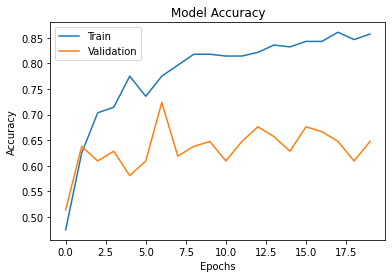

In [18]:
import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#VGG16

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/20
9/9 [==============================] - 79s 9s/step - loss: 1.1182 - categorical_accuracy: 0.3286 - val_loss: 1.0822 - val_categorical_accuracy: 0.3810
Epoch 2/20
9/9 [==============================] - 76s 8s/step - loss: 1.0950 - categorical_accuracy: 0.3964 - val_loss: 1.0873 - val_categorical_accuracy: 0.3905
Epoch 3/20
9/9 [==============================] - 76s 8s/step - loss: 1.0820 - categorical_accuracy: 0.4036 - val_loss: 1.0663 - val_categorical_accuracy: 0.4190
Epoch 4/20
9/9 [==============================] - 76s 8s/step - loss: 1.0685 - categorical_accuracy: 0.4464 - val_loss: 1.0692 - val_categorical_accuracy: 0.4190
Epoch 5/20
9/9 [==============================] - 76s 8s/step - loss: 1.0596 - categorical_accuracy: 0.4786 - val_loss: 1.0554 - val_categorical_accuracy: 0.4762
Epoch 6/20
9/9 [==============================] - 76s 8s/step - loss: 1.0479 - categorical_accuracy: 0.4607 - val_loss: 1.058

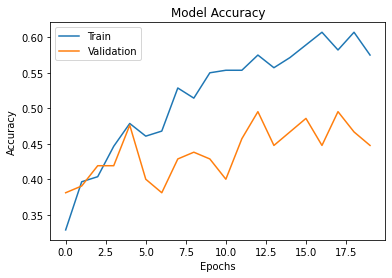

In [19]:
import keras as keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#VGG 19 

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/20
9/9 [==============================] - 100s 11s/step - loss: 1.2958 - categorical_accuracy: 0.3179 - val_loss: 1.1107 - val_categorical_accuracy: 0.3429
Epoch 2/20
9/9 [==============================] - 95s 11s/step - loss: 1.1139 - categorical_accuracy: 0.3750 - val_loss: 1.1316 - val_categorical_accuracy: 0.3619
Epoch 3/20
9/9 [==============================] - 95s 11s/step - loss: 1.1127 - categorical_accuracy: 0.3964 - val_loss: 1.1122 - val_categorical_accuracy: 0.3714
Epoch 4/20
9/9 [==============================] - 96s 11s/step - loss: 1.0854 - categorical_accuracy: 0.4000 - val_loss: 1.0876 - val_categorical_accuracy: 0.3905
Epoch 5/20
9/9 [==============================] - 98s 11s/step - loss: 1.0791 - categorical_accuracy: 0.3857 - val_loss: 1.0782 - val_categorical_accuracy: 0.3905
Epoch 6/20
9/9 [==============================] - 95s 11s/step - loss: 1.0656 - categorical_accuracy: 0.4357 - val_loss

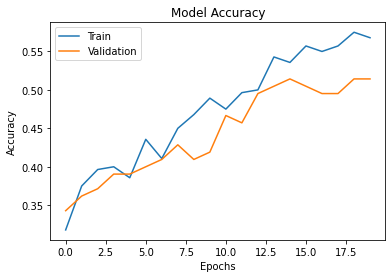

In [20]:
import keras as keras

base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#ResNet50

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/20
9/9 [==============================] - 27s 3s/step - loss: 1.0974 - categorical_accuracy: 0.3750 - val_loss: 1.1100 - val_categorical_accuracy: 0.3524
Epoch 2/20
9/9 [==============================] - 26s 3s/step - loss: 1.0982 - categorical_accuracy: 0.3929 - val_loss: 1.1026 - val_categorical_accuracy: 0.3524
Epoch 3/20
9/9 [==============================] - 26s 3s/step - loss: 1.0946 - categorical_accuracy: 0.4036 - val_loss: 1.0918 - val_categorical_accuracy: 0.3619
Epoch 4/20
9/9 [==============================] - 26s 3s/step - loss: 1.0874 - categorical_accuracy: 0.4000 - val_loss: 1.0946 - val_categorical_accuracy: 0.3619
Epoch 5/20
9/9 [==============================] - 26s 3s/step - loss: 1.0885 - categorical_accuracy: 0.3929 - val_loss: 1.0997 - val_categorical_accuracy: 0.3524
Epoch 6/20
9/9 [==============================] - 26s 3s/step - loss: 1.0755 - categorical_accuracy: 0.3929 - val_loss: 1.089

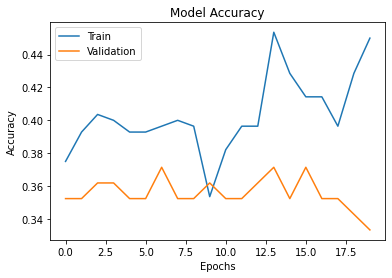

In [21]:
import keras as keras

base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#ResNet152V2

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/20
9/9 [==============================] - 73s 8s/step - loss: 1.5395 - categorical_accuracy: 0.3643 - val_loss: 1.2791 - val_categorical_accuracy: 0.4190
Epoch 2/20
9/9 [==============================] - 68s 8s/step - loss: 1.0164 - categorical_accuracy: 0.5429 - val_loss: 1.2798 - val_categorical_accuracy: 0.3810
Epoch 3/20
9/9 [==============================] - 68s 8s/step - loss: 0.8230 - categorical_accuracy: 0.6357 - val_loss: 1.1478 - val_categorical_accuracy: 0.4857
Epoch 4/20
9/9 [==============================] - 69s 8s/step - loss: 0.6552 - categorical_accuracy: 0.7321 - val_loss: 1.1222 - val_categorical_accuracy: 0.4667
Epoch 5/20
9/9 [==============================] - 69s 8s/step - loss: 0.5712 - categorical_accuracy: 0.7893 - val_loss: 1.1284 - val_categorical_accuracy: 0.4857
Epoch 6/20
9/9 [==============================] - 68s 8s/step - loss: 0.5468 - categorical_accuracy: 0.7893 - val_loss: 1.0

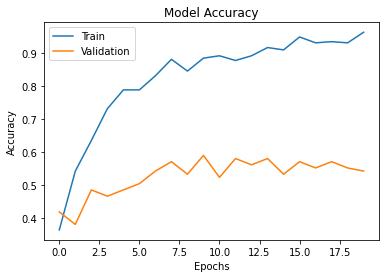

In [22]:
import keras as keras

base_model = keras.applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#InceptionResNetV2

219062272/219055592 [==============================] - 2s 0us/step
Epoch 1/20
9/9 [==============================] - 34s 4s/step - loss: 1.5054 - categorical_accuracy: 0.4071 - val_loss: 1.4421 - val_categorical_accuracy: 0.4476
Epoch 2/20
9/9 [==============================] - 32s 4s/step - loss: 1.0403 - categorical_accuracy: 0.5679 - val_loss: 1.2224 - val_categorical_accuracy: 0.5143
Epoch 3/20
9/9 [==============================] - 31s 3s/step - loss: 0.8959 - categorical_accuracy: 0.6464 - val_loss: 1.1743 - val_categorical_accuracy: 0.5238
Epoch 4/20
9/9 [==============================] - 31s 3s/step - loss: 0.8553 - categorical_accuracy: 0.6536 - val_loss: 1.3339 - val_categorical_accuracy: 0.5333
Epoch 5/20
9/9 [==============================] - 31s 3s/step - loss: 0.8323 - categorical_accuracy: 0.6429 - val_loss: 1.1394 - val_categorical_accuracy: 0.5429
Epoch 6/20
9/9 [==============================] - 31s 3s/step - loss: 0.6735 - categorical_accuracy: 0.7000 - val_loss: 1.1

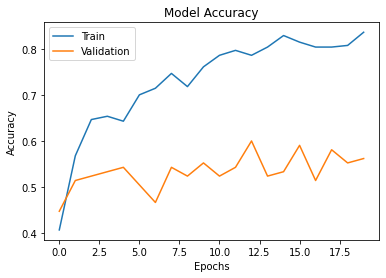

In [23]:
import keras as keras

base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#MobileNetV2

In [ ]:
import keras as keras

base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()


#DenseNet201

74842112/74836368 [==============================] - 0s 0us/step
Epoch 1/20
9/9 [==============================] - 35s 4s/step - loss: 1.4242 - categorical_accuracy: 0.3893 - val_loss: 1.2323 - val_categorical_accuracy: 0.4381
Epoch 2/20
9/9 [==============================] - 32s 4s/step - loss: 1.1293 - categorical_accuracy: 0.4893 - val_loss: 1.1345 - val_categorical_accuracy: 0.4762
Epoch 3/20
9/9 [==============================] - 33s 4s/step - loss: 0.9197 - categorical_accuracy: 0.6036 - val_loss: 1.0322 - val_categorical_accuracy: 0.5048
Epoch 4/20
9/9 [==============================] - 32s 4s/step - loss: 0.7973 - categorical_accuracy: 0.6500 - val_loss: 0.9629 - val_categorical_accuracy: 0.5714
Epoch 5/20
9/9 [==============================] - 32s 4s/step - loss: 0.7185 - categorical_accuracy: 0.6929 - val_loss: 0.9152 - val_categorical_accuracy: 0.5429
Epoch 6/20
9/9 [==============================] - 36s 4s/step - loss: 0.6969 - categorical_accuracy: 0.7000 - val_loss: 0.916

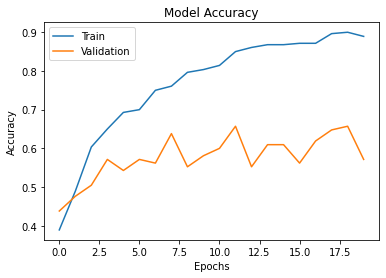

In [24]:
import keras as keras

base_model = keras.applications.DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 3 units 
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


model_history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1 )


import matplotlib.pyplot as plt
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()
